# Modelos Series de Shampoo
Universidad del Valle de Guatemala
1. Pablo Gonzalez 20362
2. Javier Mombiela 20067

In [1]:
from Def_funciones import *

import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error

#
from warnings import catch_warnings
from warnings import filterwarnings

# La librería statsmodel tiene implementaciones de SARIMA y de Holt-Winters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Si el computador tiene procesadores múltiples, se aprovecharán
#from multiprocessing import cpu_count

from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed


In [2]:
data = pd.read_csv('shampoo.csv')
data.dtypes

Month     object
Sales    float64
dtype: object

In [3]:
data.info


<bound method DataFrame.info of    Month  Sales
0   1-01  266.0
1   1-02  145.9
2   1-03  183.1
3   1-04  119.3
4   1-05  180.3
5   1-06  168.5
6   1-07  231.8
7   1-08  224.5
8   1-09  192.8
9   1-10  122.9
10  1-11  336.5
11  1-12  185.9
12  2-01  194.3
13  2-02  149.5
14  2-03  210.1
15  2-04  273.3
16  2-05  191.4
17  2-06  287.0
18  2-07  226.0
19  2-08  303.6
20  2-09  289.9
21  2-10  421.6
22  2-11  264.5
23  2-12  342.3
24  3-01  339.7
25  3-02  440.4
26  3-03  315.9
27  3-04  439.3
28  3-05  401.3
29  3-06  437.4
30  3-07  575.5
31  3-08  407.6
32  3-09  682.0
33  3-10  475.3
34  3-11  581.3
35  3-12  646.9>

In [4]:
data.shape

(36, 2)

In [5]:
pd.set_option('display.width',100)
pd.set_option('display.precision',3)
data.describe()

,Sales
count,36.000
mean,312.600
std,148.937
min,119.300
25%,192.450
50%,280.150
75%,411.100
max,682.000


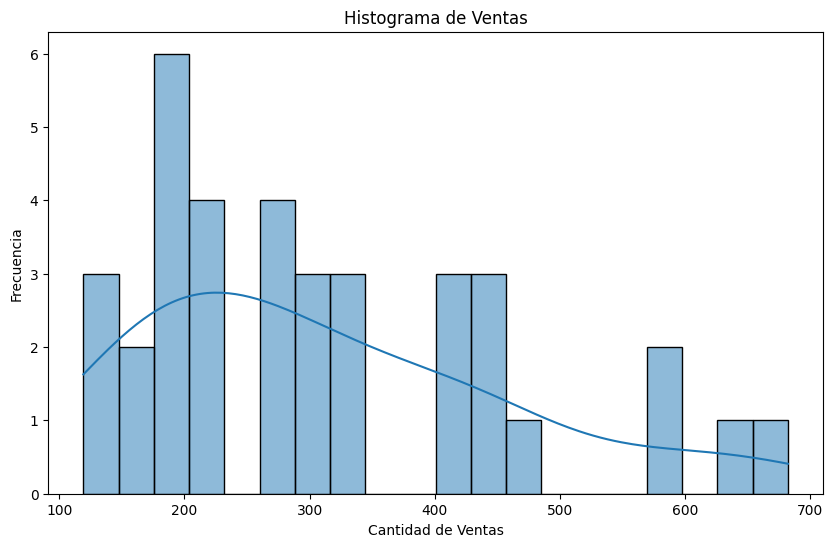

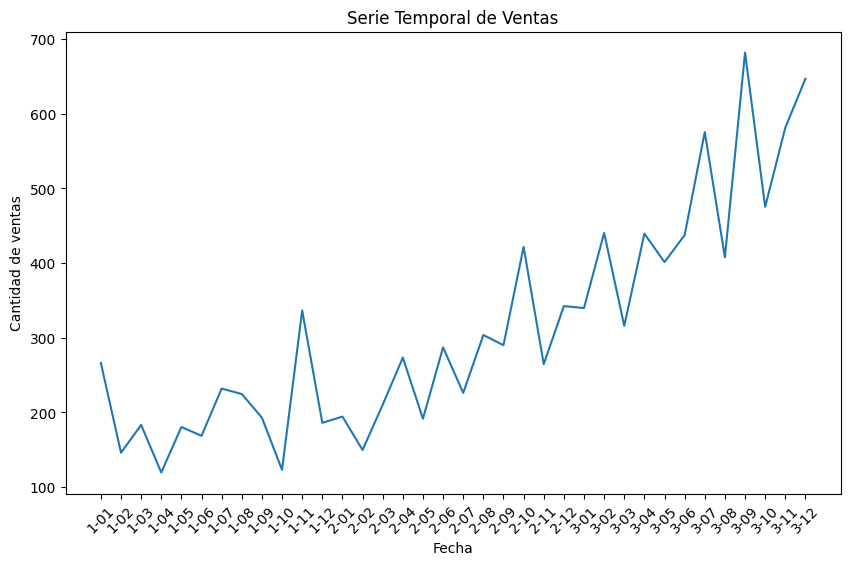

In [7]:

# Histograma de ventas
plt.figure(figsize=(10, 6))
sns.histplot(data["Sales"], bins=20, kde=True)
plt.xlabel("Cantidad de Ventas")
plt.ylabel("Frecuencia")
plt.title("Histograma de Ventas")
plt.show()

# Serie temporal de nacimientos
plt.figure(figsize=(10, 6))
sns.lineplot(x="Month", y="Sales", data=data)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de ventas")
plt.title("Serie Temporal de Ventas")
plt.xticks(rotation=45)
plt.show()

In [8]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [9]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

In [10]:
def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = executor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

In [11]:
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

In [12]:
def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

In [13]:
def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

In [14]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

In [15]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional=[0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]

    # Si m es mayor que cero, generar configuraciones estacionales
    m_params = estacional

    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    modelos.append(cfg)
    return modelos


In [16]:
def prediccion_alisamiento_exp(historia, configuracion):
    # Crear una serie de tiempo a partir de la historia
    serie_tiempo = pd.Series(historia)
    
    # Aplicar el modelo de Holt-Winters exponencial
    modelo = ExponentialSmoothing(serie_tiempo, 
                                  trend=configuracion[0], 
                                  seasonal=configuracion[1], 
                                  seasonal_periods=configuracion[2])
    
    # Ajustar el modelo a los datos históricos
    modelo_ajustado = modelo.fit()
    
    # Realizar una predicción de un paso hacia adelante
    prediccion = modelo_ajustado.forecast(steps=1)
    
    return prediccion[0]

def config_alisamiento_exp(estacional = [None]): 
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

### Promedio

Tamaño Entrenamiento 29
Tamaño Prueba 7
Mse:  161.30044725825866


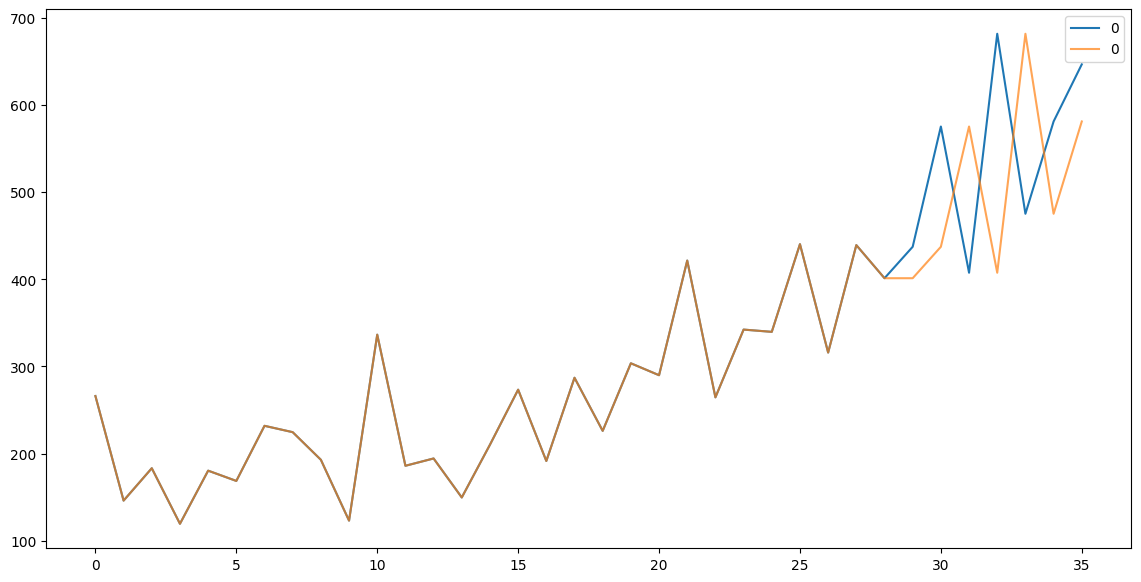

In [17]:
series = pd.read_csv('shampoo.csv', header = 0, index_col = 0)
datos = series.values
n_prueba = int(len(datos) * 0.2)
long_max = len(datos) - n_prueba
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")
cfg = config_simple(long_max)[1]
entreno, prueba = division_entreno_prueba(datos, n_prueba)
historia = [x for x in entreno]
predicciones = []
for i in range(len(prueba)):
    yhat = prediccion_promedio(historia, cfg)
    predicciones.append(yhat)
    historia.append(prueba[i])

error = medir_rmse(prueba, predicciones)
print("Mse: ",error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)


ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

nombre = "daily-total-female-births"
metodo = "promedio"
    
plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
plt.show()


### Sarima

In [31]:
datos = series.values
n_prueba = 30
long_max = len(datos) - n_prueba

lista_cfg = config_sarima()
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")

entreno, prueba = division_entreno_prueba(datos, n_prueba)
historia = [x for x in entreno]
predicciones = []

lista_cfg =  random.sample(lista_cfg, k = 5)
for cfg in lista_cfg:
    for i in range(len(prueba)):
        try:
            with catch_warnings():
                yhat = prediccion_sarima(historia, cfg)
                predicciones.append(yhat)
                historia.append(prueba[i])
        except:
            error = None

# Keep only the non-empty predictions

error = sqrt(mean_squared_error(prueba, predicciones))

Tamaño Entrenamiento 6
Tamaño Prueba 30


c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 77.70073260864471


<Axes: >

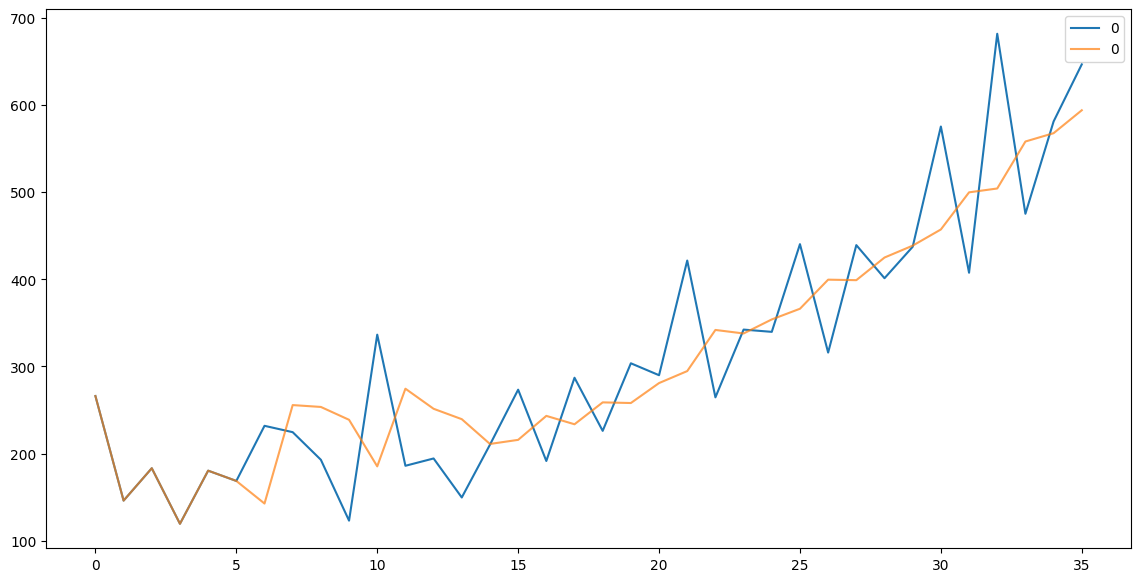

In [32]:
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

### Alisamiento Exponencial

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


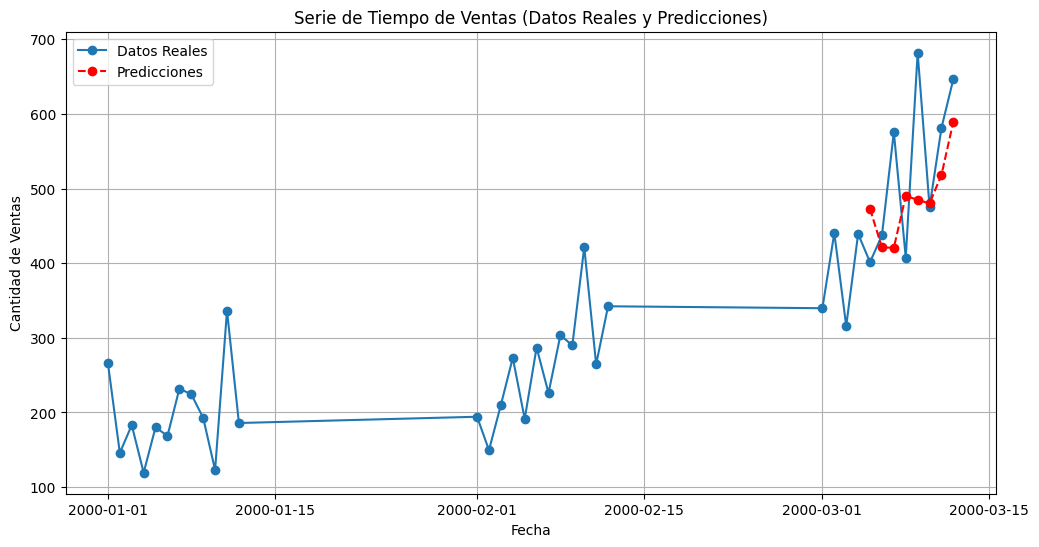

RMSE: 101.32987763396055


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Cargar los datos desde el archivo CSV
df = pd.read_csv('shampoo.csv')

# Agregar un año fijo a tus datos (por ejemplo, 2000)
df['Year'] = 2000

# Combinar 'Year' y 'Month' en una columna de fecha completa
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%m-%d')

# Establecer la columna 'Date' como índice
df.set_index('Date', inplace=True)

# Eliminar las columnas 'Month' y 'Year' si ya no son necesarias
df.drop(['Month', 'Year'], axis=1, inplace=True)

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Aplicar el modelo de alisamiento exponencial al conjunto de entrenamiento
modelo = ExponentialSmoothing(train['Sales'], trend='add', seasonal='add', seasonal_periods=7)
resultado = modelo.fit()

# Hacer predicciones en el conjunto de prueba
predicciones = resultado.forecast(steps=len(test))  # Predicción para la longitud del conjunto de prueba

# Visualizar las predicciones y el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-', label='Datos Reales')
plt.plot(test.index, predicciones, marker='o', linestyle='--', color='red', label='Predicciones')
plt.legend()
plt.title('Serie de Tiempo de Ventas (Datos Reales y Predicciones)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ventas')
plt.grid(True)
plt.show()

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(test['Sales'], predicciones))
print("RMSE:", rmse)


### Prophet

In [56]:
from prophet import Prophet
# Cargar los datos desde el archivo CSV
series = pd.read_csv('shampoo.csv', header=0, index_col=None)

date_format = "%d-%m"
series = pd.read_csv('shampoo.csv')
series['ds'] = pd.to_datetime(series['Month'], format=date_format)
series['y'] = series['Sales']
series = series[['ds', 'y']]
series.head()

,ds,y
0,1900-01-01,266.0
1,1900-02-01,145.9
2,1900-03-01,183.1
3,1900-04-01,119.3
4,1900-05-01,180.3


In [57]:
modelo = Prophet(mcmc_samples=500, seasonality_mode='multiplicative')
modelo_ajustado = modelo.fit(series)
futuro = modelo_ajustado.make_future_dataframe(periods=48, freq='M')
prediccion = modelo_ajustado.predict(futuro)
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

13:31:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▊       | 00:00 Iteration:   1 / 500 [  0%]  (Warmup)




chain 1 |█████▋    | 00:00 Iteration: 200 / 500 [ 40%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


13:31:02 - cmdstanpy - INFO - CmdStan done processing.
13:31:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

,ds,yhat,yhat_lower,yhat_upper
79,1904-07-31,947.797,-81.754,2124.499
80,1904-08-31,1107.156,-94.056,2495.370
81,1904-09-30,893.538,-58.548,2042.868
82,1904-10-31,1334.803,-105.839,2993.140
83,1904-11-30,1155.234,-132.350,2651.720


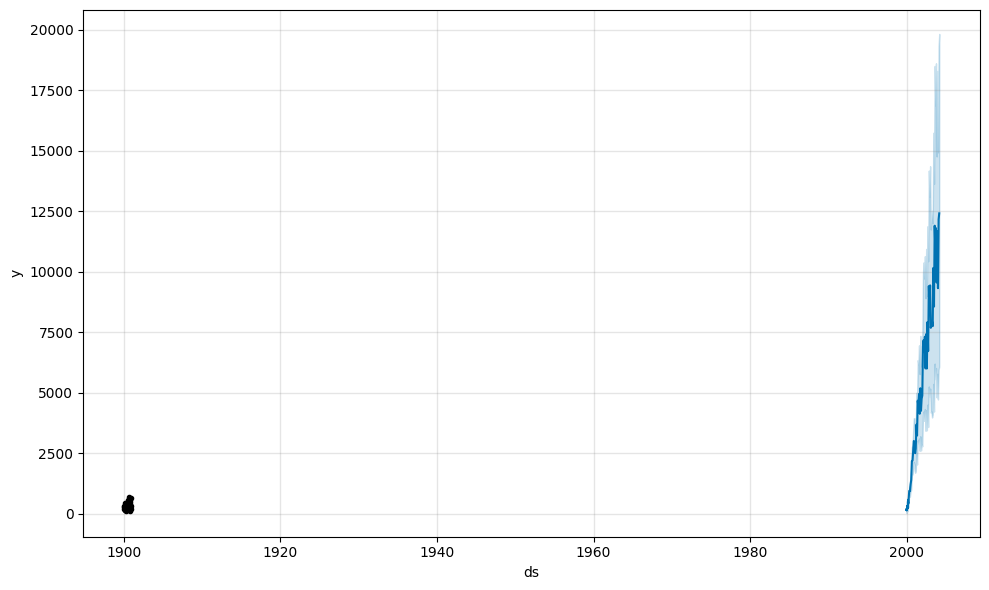

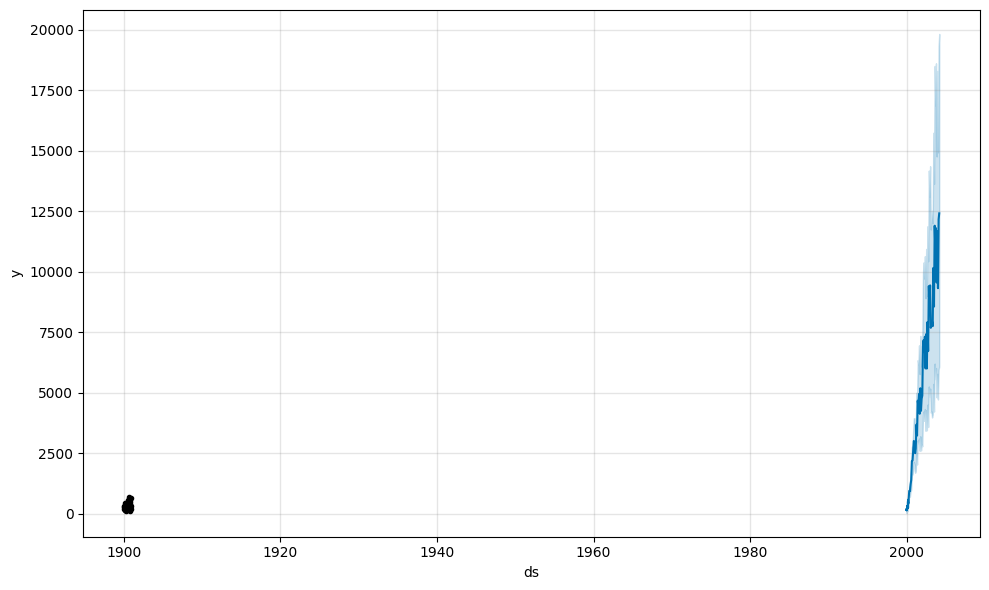

In [58]:
modelo.plot(predicciones_Prophet)

In [60]:
error = sqrt(mean_squared_error(series['y'], predicciones_Prophet['yhat'][0:36]))
print("MSE:", error)

MSE: 59.81274433143918


### Redes Neuronales

In [61]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values

In [63]:
def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

In [64]:
def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

In [65]:
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

In [66]:
def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

In [67]:
def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()

In [68]:
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()

 > 111.992
 > 120.231
 > 112.006
 > 103.995
 > 118.606
mlp: 113.366 RMSE (+/- 5.764)


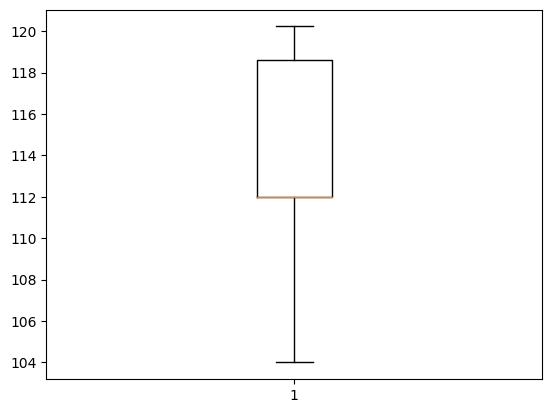

<Figure size 640x480 with 0 Axes>

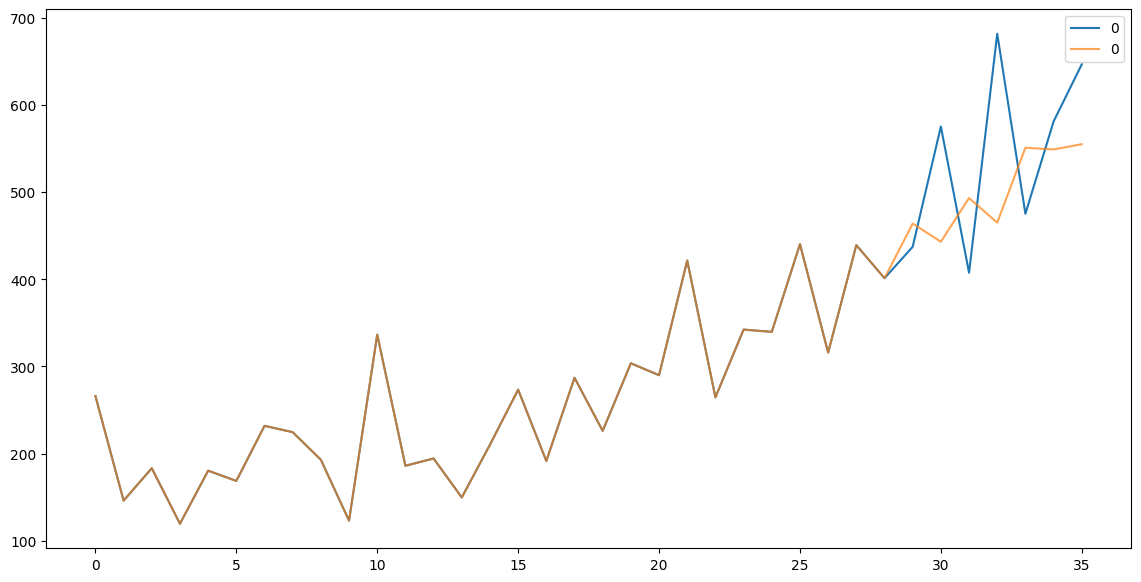

In [69]:
series = pd.read_csv('shampoo.csv', header=0,index_col=0)
buscar_mejor_solucion(series,"nacimientos")

### Discusión de Resultados

1. Método de Promedios (PromedioMse): RMSE = 161.30

- El método de promedios es uno de los enfoques más simples para predecir series de tiempo. Calcula el promedio de los valores históricos y utiliza ese valor como predicción.
- En este caso, el RMSE es relativamente alto, lo que sugiere que este enfoque no se ajusta bien a los datos y tiene un error significativo en sus predicciones.

2. SARIMA (Sarima MSE): RMSE = 77.70

- SARIMA (Seasonal Autoregressive Integrated Moving Average) es un modelo estadístico que tiene en cuenta la estacionalidad y la autocorrelación en los datos de series de tiempo.
- El RMSE para el modelo SARIMA es más bajo que el del método de promedios, lo que indica que SARIMA se ajusta mejor a los datos y tiene un error de predicción más bajo.

3. Aislamiento Exponencial (Aislamiento exponencial RMSE): RMSE = 101.33

- El aislamiento exponencial es otro método que se utiliza para modelar series de tiempo, especialmente cuando hay tendencias y estacionalidades presentes.
- El RMSE es más alto que el del modelo SARIMA, lo que sugiere que el aislamiento exponencial tiene un rendimiento inferior en este conjunto de datos en comparación con SARIMA.

4. Red Neuronal (Red neuronal RMSE): RMSE = 5.76

- Las redes neuronales, especialmente las redes neuronales recurrentes (RNN) o las redes neuronales de memoria a largo plazo (LSTM), son capaces de capturar patrones complejos en series de tiempo.
- El RMSE extremadamente bajo para la red neuronal es sorprendente y sugiere que este modelo se ajusta excepcionalmente bien a los datos. Esto podría deberse a su capacidad para aprender relaciones no lineales y capturar patrones a largo plazo en los datos de la serie de tiempo.

**Conclusiones**
- La Red Neuronal es el Mejor Modelo para Predecir las Ventas de Shampoo: Basándonos en los valores de RMSE proporcionados, la red neuronal es claramente el modelo que ofrece las predicciones más precisas. Con un RMSE de solo 5.76, supera significativamente a los otros modelos. Esto sugiere que la capacidad de las redes neuronales para capturar patrones complejos en los datos de series de tiempo es fundamental en este contexto. Su capacidad para adaptarse a relaciones no lineales y aprender a partir de datos históricos a largo plazo le otorga una ventaja sobre los modelos estadísticos tradicionales.

- SARIMA Ofrece un Desempeño Sólido: Aunque la red neuronal es la clara ganadora en términos de precisión, no debemos pasar por alto que el modelo SARIMA también proporciona un rendimiento bastante sólido con un RMSE de 77.70. Este modelo estadístico tiene en cuenta la estacionalidad y la autocorrelación en los datos y podría ser una opción aceptable si se necesitan predicciones precisas pero se prefieren modelos más interpretables y menos complejos que las redes neuronales.

- El Método de Promedios Debe Evitarse para este Conjunto de Datos: El método de promedios, con un RMSE de 161.30, es el modelo menos preciso en este contexto. Esto indica que simplemente tomar el promedio de los valores históricos no es una estrategia efectiva para predecir las ventas de shampoo en este conjunto de datos. En la mayoría de los casos, se deben considerar modelos más sofisticados para lograr predicciones más precisas.